In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import pickle
from glob import glob
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
    

GPU is available


In [3]:
#train_path = "./train_tracked_agent"
train_path = "../train/train"
# The glob module finds all the pathnames matching a specified pattern
train_pkl_lst = glob(os.path.join(train_path, '*'))
#with open(train_pkl_lst[1], 'rb') as f:
#    training_sample = pickle.load(f)

In [4]:
print(len(train_pkl_lst))

205942


# LSTM

In [48]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(MyLSTM, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
    
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        #Initializing hidden state for first input using method defined below
        h_t, c_t = self.init_hidden(batch_size)

        #print(x.size())
        #print(x.size(-1))
        # Passing in the input and hidden state into the model and obtaining outputs
        #print(x.shape)
        #print(h_t.shape)
        #print(c_t.shape)

        #print(f'forward pass: input shape is {x.shape}')
        out, (h_t, c_t) = self.lstm(x, (h_t, c_t))
        #print(f'forward pass: lstm output is {out.shape}')
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        #print(f'forward pass: result of reshaping output before passing to fc layer is {out.shape}')
        out = self.fc(out)
        #print(f'forward pass: fc output is {out.shape}')
        
        return out, h_t
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        c_0 =  torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)       
         # We'll send the tensor holding the hidden state to the device we specified earlier as well
        return h_0, c_0

In [49]:
# Autogressive vs. direct mapping
# Batch Norm? 

# Dataset

In [50]:
class ArgoverseDataset(torch.utils.data.Dataset):
    """Dataset class for Argoverse"""
    
    def __init__(self, 
                 data_path,
                 sample_indices):
        super(ArgoverseDataset, self).__init__()
        
        self.data_path = data_path
        self.sample_indices = sample_indices
        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        
        # Load one scene
        pkl_path = self.pkl_list[self.sample_indices[idx]]
        with open(pkl_path, 'rb') as f:
            scene = pickle.load(f)
            
#         # the index of agent to be predicted 
#         pred_id = np.where(scene["track_id"] == scene['agent_id'])[0][0]
        
#         # input: p_in & v_in; output: p_out
#         inp_scene = np.dstack([scene['p_in'], scene['v_in']])
#         out_scene = np.dstack([scene['p_out'], scene['v_out']])
        
#         # Normalization 
#         min_vecs = np.min(inp_scene, axis = (0,1))
#         max_vecs = np.max(inp_scene, axis = (0,1))
        
#         # Normalize by vectors
#         inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
#         out = (out_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        inp = scene['inp']
        out = scene['out']
        
        #print(inp.shape)
        #print(inp.flatten().shape)
        inp = inp.reshape(1, -1)
        out = out[:, :2].reshape(-1) # reshape to 60x1 so it matches shape of model output
        
        #inp = inp.flatten()
        #out = out[:, :2].flatten()
        
        #inp = inp.reshape(-1, 1)
        #out = out[:, :2].reshape(-1, 1)
        
        return torch.from_numpy(inp).float(), torch.from_numpy(out).float()
    
        #dat = np.concatenate((inp, out), axis=0)
        
        #train_data = []
        #window_size = 20
        #interval = 7
        #for i in range(0, len(dat), interval):
        #    #print(len(dat[i:i+input_length]))
        #    if i + window_size < len(dat): 
        #        train_data.append(dat[i:i+window_size])
            
        #print(len(train_data))
        #print(train_data)
        
        #input_seq = []
        #target_seq = []
        #for i in range(len(train_data)):
        #    input_seq.append(train_data[i][:-1])
        #    target_seq.append(train_data[i][1:])
        
        #print(input_seq)
        
        #input_seq = np.array(input_seq, dtype=np.float32)
        #target_seq = np.array(target_seq, dtype=np.float32)
        
        #print(input_seq.shape)
        #print(target_seq.shape)
        
        ## Convert to float torch tensor
        ##return torch.from_numpy(inp).float(), torch.from_numpy(out).float() #torch.from_numpy(out[:,:2]).float()
        #return torch.from_numpy(input_seq).float(), torch.from_numpy(target_seq).float()

In [51]:
# Try different ways of normalization
# Leverage other features. 

# Hyperparameter

In [52]:
# Grid/Random Search

In [53]:
# batch_size = 64
interval = 7 # sampling interval for LSTM
window_size = 20 # number of timesteps to take as input
batch_size = 512
#in_dim = 19*4 # MLP
#out_dim = 4 #30*2 # MLP
input_size = 19*4 #1#19*4 # LSTM
output_size = 30*2 # LSTM (has to match input_size)
hidden_dim = 128 #128 #256 #128 #32 #128
num_layers = 1 #1 #3
learning_rate = 0.01
decay_rate = 0.95
num_epoch = 1000

# Data Loader

In [54]:
train_path = "./train_tracked_agent"

# total number of scenes
indices = np.arange(0, 205942)

# train-valid split
np.random.shuffle(indices)
train_indices = indices[:180000]
valid_indices = indices[180000:]

# define datasets
train_set = ArgoverseDataset(train_path, train_indices)
valid_set = ArgoverseDataset(train_path, valid_indices)

# create dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [55]:
len(train_set)

180000

In [56]:
# train_set[0]

In [57]:
len(train_loader)

352

# Model, Loss Function and Optimizer

In [58]:
# # RNN, LSTM, 1dCNN, Transformer
# model = MLPNet(in_dim = in_dim, 
#                out_dim = out_dim,
#                hidden_dim = hidden_dim, 
#                num_layers = num_layers).to(device) # move model to gpu 

model = MyLSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=num_layers).to(device)

# Adaptive Moment Estimation computes adaptive learning rates for each parameter. 
# Compute the decaying averages of past and past squared gradients. 

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=decay_rate)  # stepwise learning rate decay
loss_fun = nn.MSELoss()

# Training

In [74]:
for inp, tgt in train_loader:
    print(inp.shape)
    print(tgt.shape)
    
    inp = inp.to(device)
    print(inp.shape)
    break
        

torch.Size([512, 1, 76])
torch.Size([512, 60])
torch.Size([512, 1, 76])


In [72]:
def train_epoch(train_loader, model, optimizer, loss_function):

    train_mse = []
    for inp, tgt in tqdm(train_loader):
        
        #inp = inp.view(-1, window_size-1, 4)
        #tgt = tgt.view(-1, window_size-1, 4)
        
        #print(inp.size())
        
        #print(inp.shape)
        #print(tgt.shape)
        
        inp = inp.to(device)
        tgt = tgt.to(device)
        
        output, hidden = model(inp)
        output = output.to(device)
        
        #print(output.shape)
        #print(hidden.shape)
        #print(output.shape)
        #print(hidden.shape)
        #print(tgt.view(-1, 4).size())
        
        
        
        loss = loss_function(output, tgt)
        train_mse.append(loss.item()) 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_mse = round(np.sqrt(np.mean(train_mse)),5)
    
    return train_mse

def eval_epoch(valid_loader, model, loss_function):
    
    valid_mse = []
    #preds = []
    #trues = []
    
    with torch.no_grad():
        for inp, tgt in valid_loader:
            
            #inp = inp.view(-1, window_size-1, 4)
            #tgt = tgt.view(-1, window_size-1, 4)
            
            inp = inp.to(device)
            tgt = tgt.to(device)
            
            loss = 0
            output, hidden = model(inp)
            output = output.to(device)
                
            loss = loss_function(output, tgt)
            
            #preds.append(pred.cpu().data.numpy())
            #trues.append(tgt.cpu().data.numpy())
            
            valid_mse.append(loss.item())
            
        #preds = np.concatenate(preds, axis = 0)  
        #trues = np.concatenate(trues, axis = 0)  
        valid_mse = round(np.sqrt(np.mean(valid_mse)), 5)
    return valid_mse#, preds, trues


In [73]:
# Learning Rate Decay
# Dropout
# L1/L2 Regulization

In [41]:
len(train_pkl_lst)

205943

 88%|████████▊ | 309/352 [03:15<00:23,  1.81it/s]


100%|██████████| 352/352 [03:52<00:00,  1.52it/s]


[0.09942]
0.03334
Epoch 1 | T: 4.31 | Train RMSE: 0.09942 | Valid RMSE: 0.03334


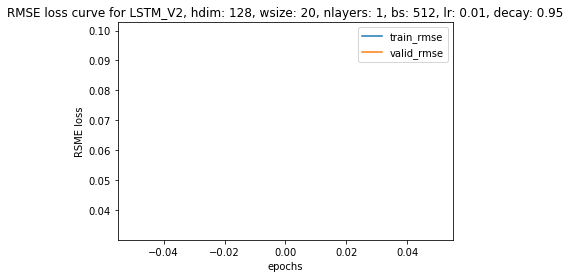

 23%|██▎       | 81/352 [00:30<01:29,  3.02it/s]


100%|██████████| 352/352 [03:37<00:00,  1.62it/s]


[0.09942, 0.02535, 0.01862]
0.01786
Epoch 3 | T: 4.11 | Train RMSE: 0.01862 | Valid RMSE: 0.01786


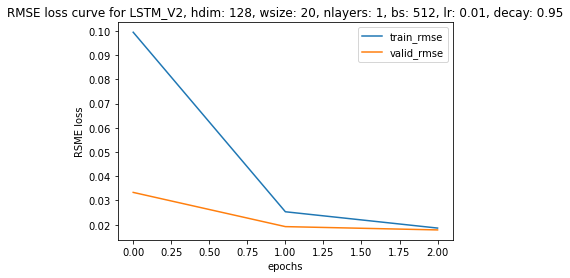

 88%|████████▊ | 308/352 [03:13<00:19,  2.23it/s]


100%|██████████| 352/352 [03:32<00:00,  1.66it/s]


[0.09942, 0.02535, 0.01862, 0.01787]
0.01678
Epoch 4 | T: 4.11 | Train RMSE: 0.01787 | Valid RMSE: 0.01678


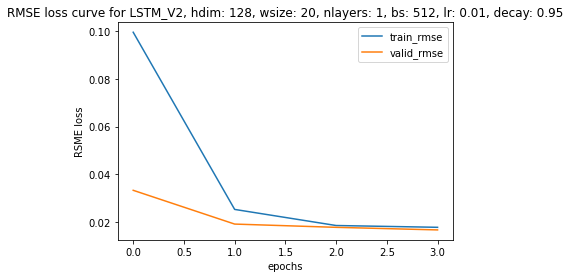

 88%|████████▊ | 308/352 [03:04<00:15,  2.78it/s]


 92%|█████████▏| 325/352 [03:11<00:10,  2.67it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


100%|██████████| 352/352 [03:28<00:00,  1.69it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674]
0.01601
Epoch 6 | T: 4.21 | Train RMSE: 0.01674 | Valid RMSE: 0.01601


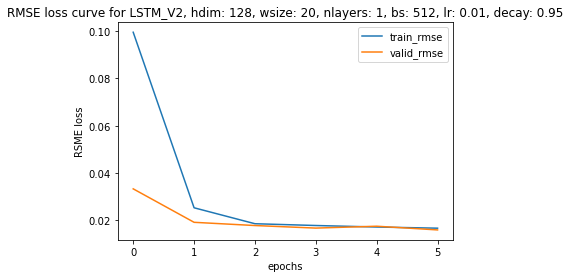

 88%|████████▊ | 308/352 [03:07<00:19,  2.29it/s]


100%|██████████| 352/352 [03:47<00:00,  1.55it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653]
0.01567
Epoch 7 | T: 4.15 | Train RMSE: 0.01653 | Valid RMSE: 0.01567


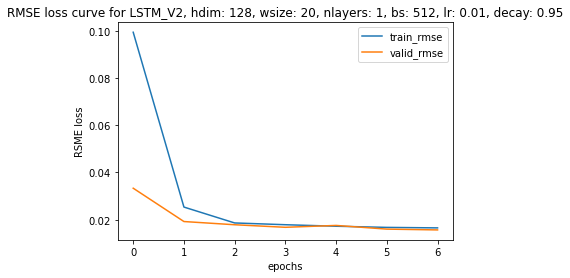

 88%|████████▊ | 308/352 [03:27<00:29,  1.48it/s]


100%|██████████| 352/352 [03:48<00:00,  1.54it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609]
0.02491
Epoch 8 | T: 4.35 | Train RMSE: 0.01609 | Valid RMSE: 0.02491


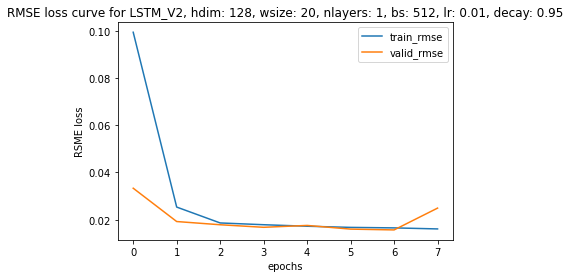

 88%|████████▊ | 308/352 [03:19<00:19,  2.25it/s]


100%|██████████| 352/352 [03:40<00:00,  1.60it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575]
0.01818
Epoch 9 | T: 4.15 | Train RMSE: 0.01575 | Valid RMSE: 0.01818


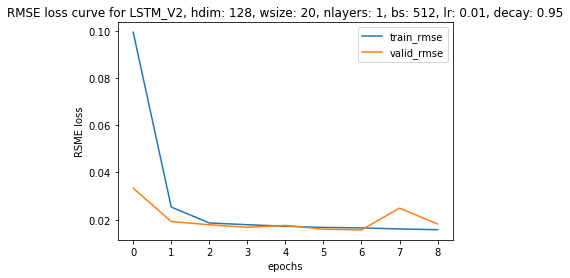

 88%|████████▊ | 308/352 [03:15<00:17,  2.49it/s]


100%|██████████| 352/352 [03:33<00:00,  1.65it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529]
0.01319
Epoch 10 | T: 4.11 | Train RMSE: 0.01529 | Valid RMSE: 0.01319


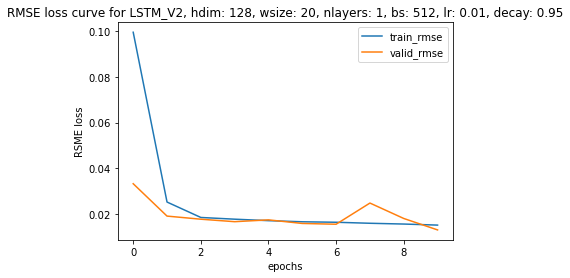

 88%|████████▊ | 308/352 [03:14<00:18,  2.36it/s]


100%|██████████| 352/352 [03:51<00:00,  1.52it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444]
0.01226
Epoch 11 | T: 4.22 | Train RMSE: 0.01444 | Valid RMSE: 0.01226


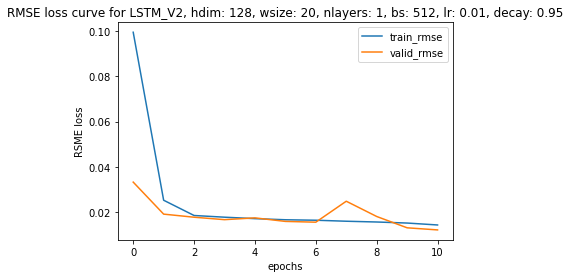

 88%|████████▊ | 308/352 [03:05<00:16,  2.67it/s]


100%|██████████| 352/352 [03:48<00:00,  1.54it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395]
0.01258
Epoch 12 | T: 4.18 | Train RMSE: 0.01395 | Valid RMSE: 0.01258


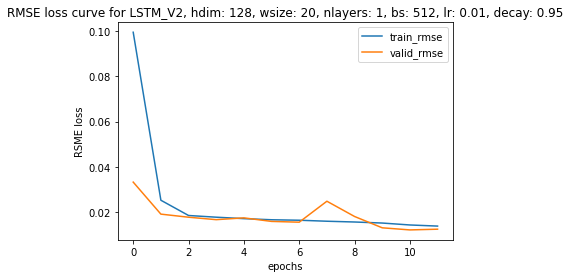

 88%|████████▊ | 308/352 [03:06<00:18,  2.39it/s]


100%|██████████| 352/352 [03:50<00:00,  1.53it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136]
0.01073
Epoch 13 | T: 4.51 | Train RMSE: 0.01360 | Valid RMSE: 0.01073


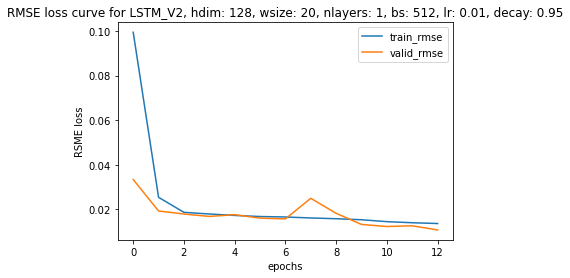

 88%|████████▊ | 308/352 [03:14<00:17,  2.58it/s]


100%|██████████| 352/352 [03:37<00:00,  1.62it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235]
0.01006
Epoch 14 | T: 4.22 | Train RMSE: 0.01235 | Valid RMSE: 0.01006


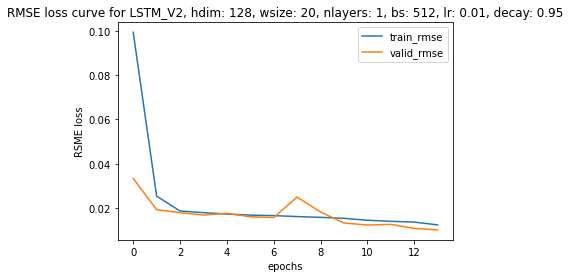

 88%|████████▊ | 308/352 [03:15<00:20,  2.13it/s]


100%|██████████| 352/352 [03:44<00:00,  1.57it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211]
0.01568
Epoch 15 | T: 4.11 | Train RMSE: 0.01211 | Valid RMSE: 0.01568


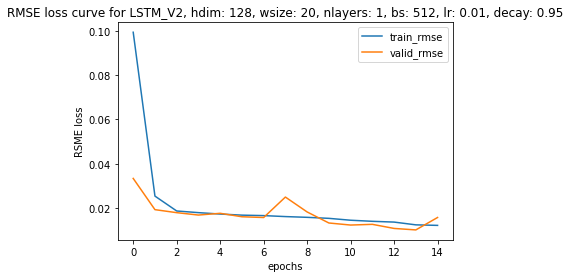

 88%|████████▊ | 308/352 [03:16<00:18,  2.44it/s]


100%|██████████| 352/352 [03:45<00:00,  1.56it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161]
0.02022
Epoch 16 | T: 4.11 | Train RMSE: 0.01161 | Valid RMSE: 0.02022


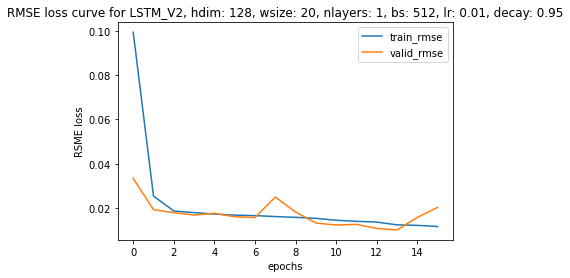

 88%|████████▊ | 308/352 [03:11<00:16,  2.65it/s]


100%|██████████| 352/352 [03:38<00:00,  1.61it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095]
0.0094
Epoch 17 | T: 4.01 | Train RMSE: 0.01095 | Valid RMSE: 0.00940


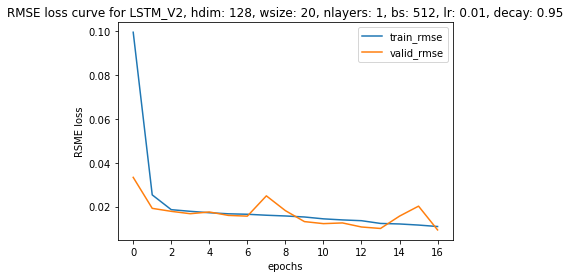

 88%|████████▊ | 308/352 [03:09<00:19,  2.31it/s]


100%|██████████| 352/352 [03:39<00:00,  1.60it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072]
0.00914
Epoch 18 | T: 4.03 | Train RMSE: 0.01072 | Valid RMSE: 0.00914


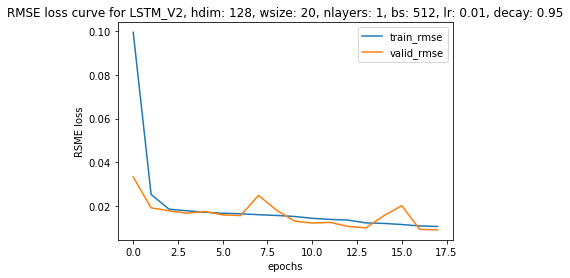

 88%|████████▊ | 308/352 [03:08<00:17,  2.54it/s]


100%|██████████| 352/352 [03:40<00:00,  1.59it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019]
0.00954
Epoch 19 | T: 4.04 | Train RMSE: 0.01019 | Valid RMSE: 0.00954


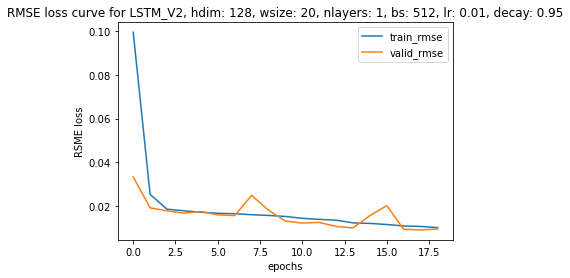

 88%|████████▊ | 308/352 [03:28<01:14,  1.69s/it]


100%|██████████| 352/352 [03:45<00:00,  1.56it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986]
0.01031
Epoch 20 | T: 4.10 | Train RMSE: 0.00986 | Valid RMSE: 0.01031


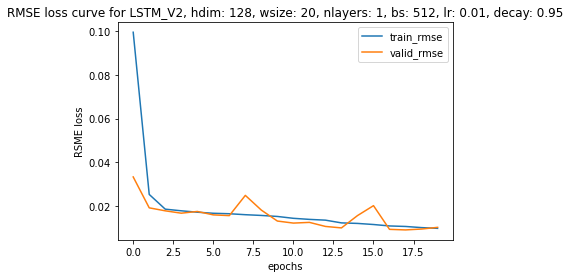

 88%|████████▊ | 308/352 [03:28<00:17,  2.55it/s]


100%|██████████| 352/352 [03:47<00:00,  1.55it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937]
0.01191
Epoch 21 | T: 4.67 | Train RMSE: 0.00937 | Valid RMSE: 0.01191


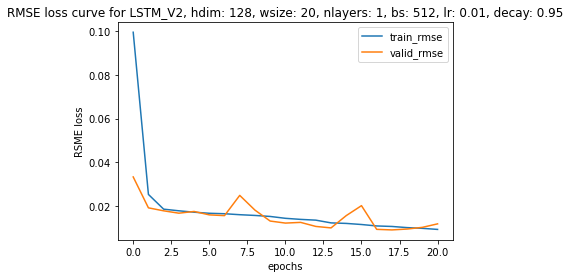

 88%|████████▊ | 308/352 [02:59<00:19,  2.31it/s]


100%|██████████| 352/352 [03:19<00:00,  1.77it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092]
0.00976
Epoch 22 | T: 4.20 | Train RMSE: 0.00920 | Valid RMSE: 0.00976


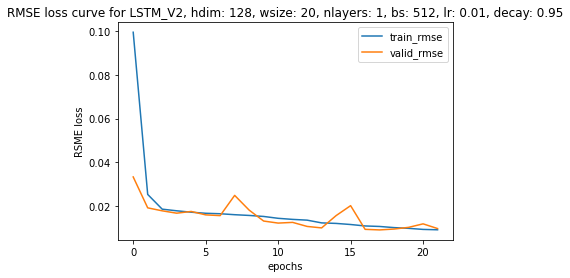

 88%|████████▊ | 308/352 [02:57<00:18,  2.33it/s]


100%|██████████| 352/352 [03:51<00:00,  1.52it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893]
0.00837
Epoch 23 | T: 4.38 | Train RMSE: 0.00893 | Valid RMSE: 0.00837


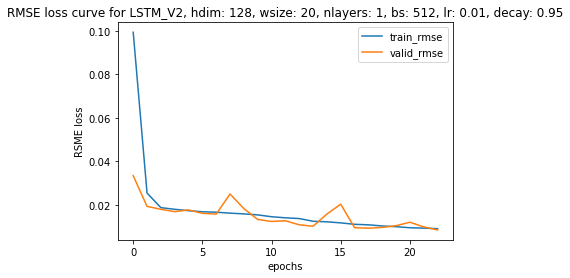

 88%|████████▊ | 308/352 [02:48<00:18,  2.43it/s]


100%|██████████| 352/352 [03:39<00:00,  1.60it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903]
0.0111
Epoch 24 | T: 4.16 | Train RMSE: 0.00903 | Valid RMSE: 0.01110


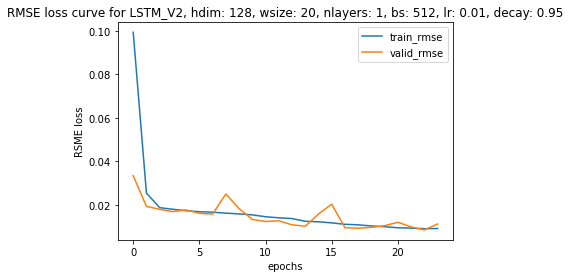

 88%|████████▊ | 308/352 [03:18<00:20,  2.16it/s]


100%|██████████| 352/352 [03:38<00:00,  1.61it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837]
0.00814
Epoch 25 | T: 4.11 | Train RMSE: 0.00837 | Valid RMSE: 0.00814


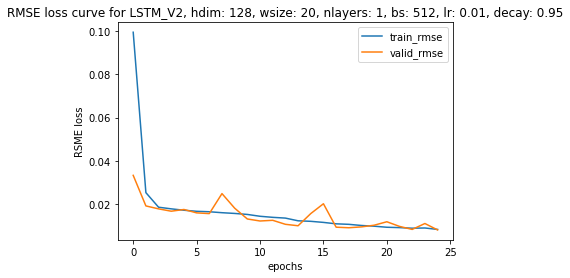

 88%|████████▊ | 308/352 [03:19<00:20,  2.14it/s]


100%|██████████| 352/352 [03:47<00:00,  1.55it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834]
0.00785
Epoch 26 | T: 4.15 | Train RMSE: 0.00834 | Valid RMSE: 0.00785


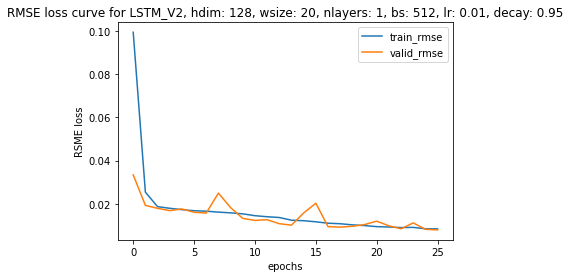

 88%|████████▊ | 308/352 [03:12<00:18,  2.32it/s]


100%|██████████| 352/352 [03:41<00:00,  1.59it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827]
0.00789
Epoch 27 | T: 4.07 | Train RMSE: 0.00827 | Valid RMSE: 0.00789


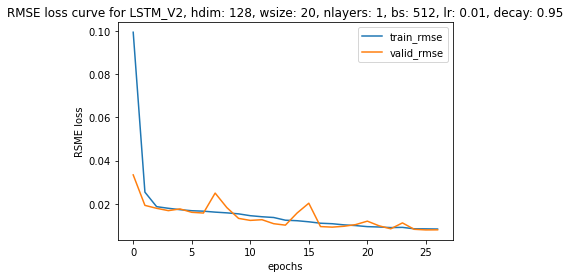

 88%|████████▊ | 308/352 [03:08<00:18,  2.35it/s]


100%|██████████| 352/352 [03:44<00:00,  1.57it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081]
0.00882
Epoch 28 | T: 4.11 | Train RMSE: 0.00810 | Valid RMSE: 0.00882


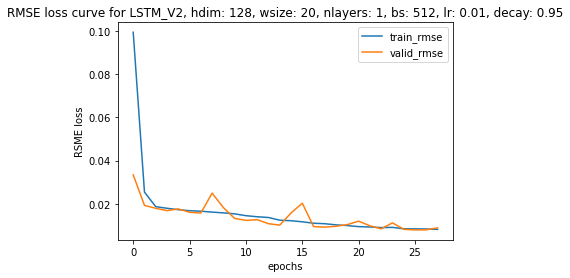

 88%|████████▊ | 308/352 [03:04<00:22,  1.98it/s]


100%|██████████| 352/352 [03:45<00:00,  1.56it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801]
0.01184
Epoch 29 | T: 4.11 | Train RMSE: 0.00801 | Valid RMSE: 0.01184


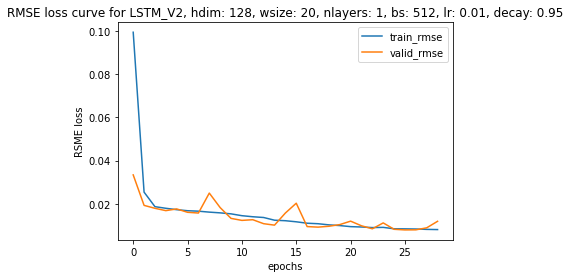

 88%|████████▊ | 308/352 [03:07<00:22,  1.94it/s]


100%|██████████| 352/352 [03:48<00:00,  1.54it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779]
0.00734
Epoch 30 | T: 4.14 | Train RMSE: 0.00779 | Valid RMSE: 0.00734


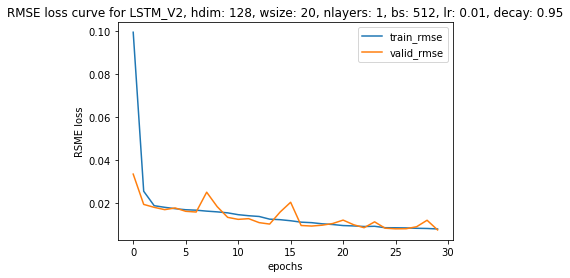

 88%|████████▊ | 308/352 [03:04<00:23,  1.87it/s]


100%|██████████| 352/352 [03:22<00:00,  1.74it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753]
0.01045
Epoch 31 | T: 4.12 | Train RMSE: 0.00753 | Valid RMSE: 0.01045


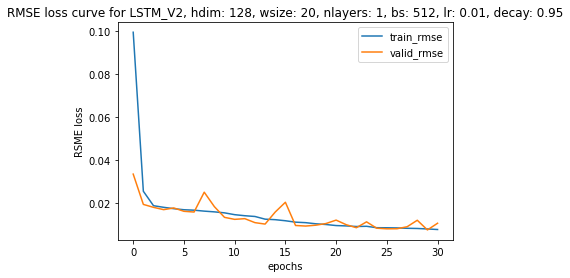

 88%|████████▊ | 308/352 [03:02<00:17,  2.46it/s]


100%|██████████| 352/352 [03:22<00:00,  1.74it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771]
0.00723
Epoch 32 | T: 4.20 | Train RMSE: 0.00771 | Valid RMSE: 0.00723


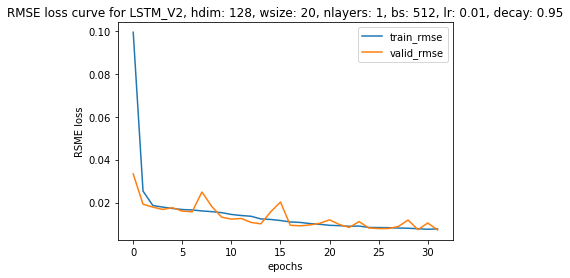

 88%|████████▊ | 308/352 [03:02<00:21,  2.04it/s]


100%|██████████| 352/352 [03:50<00:00,  1.52it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742]
0.00725
Epoch 33 | T: 4.20 | Train RMSE: 0.00742 | Valid RMSE: 0.00725


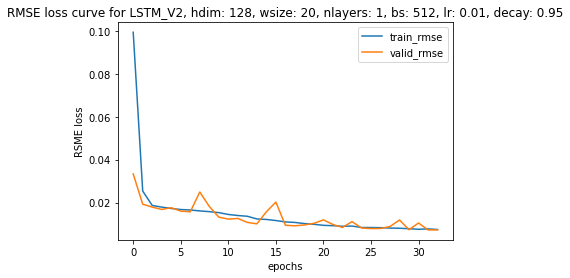

 88%|████████▊ | 308/352 [03:00<00:18,  2.44it/s]


100%|██████████| 352/352 [03:46<00:00,  1.55it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722]
0.00648
Epoch 34 | T: 4.38 | Train RMSE: 0.00722 | Valid RMSE: 0.00648


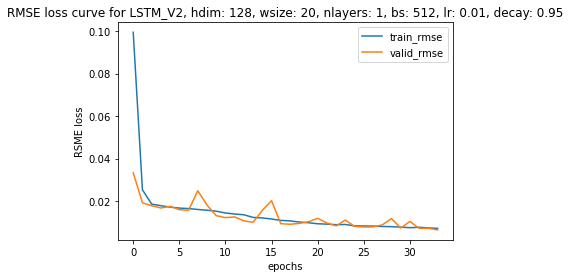

 88%|████████▊ | 308/352 [03:15<00:23,  1.83it/s]


100%|██████████| 352/352 [03:34<00:00,  1.64it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733]
0.00656
Epoch 35 | T: 4.18 | Train RMSE: 0.00733 | Valid RMSE: 0.00656


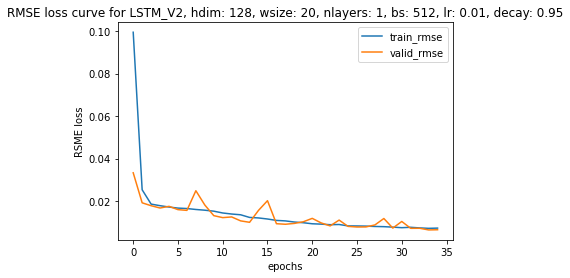

 88%|████████▊ | 308/352 [03:14<00:16,  2.59it/s]


100%|██████████| 352/352 [03:34<00:00,  1.64it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698]
0.00704
Epoch 36 | T: 4.17 | Train RMSE: 0.00698 | Valid RMSE: 0.00704


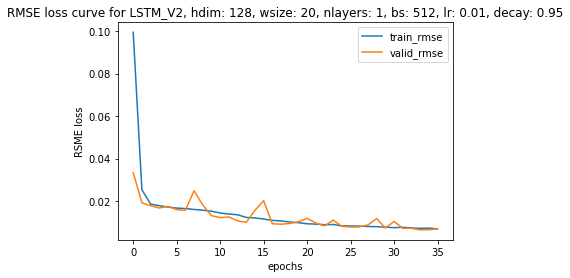

 88%|████████▊ | 308/352 [03:14<00:20,  2.13it/s]


100%|██████████| 352/352 [03:45<00:00,  1.56it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007]
0.0064
Epoch 37 | T: 4.16 | Train RMSE: 0.00700 | Valid RMSE: 0.00640


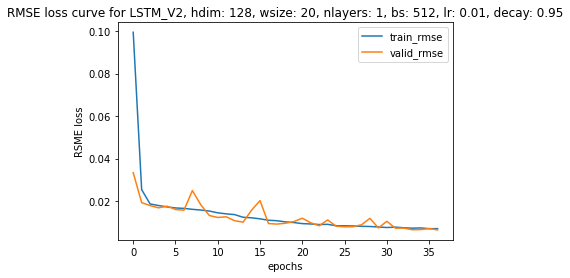

 88%|████████▊ | 308/352 [03:10<00:20,  2.19it/s]


100%|██████████| 352/352 [03:45<00:00,  1.56it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677]
0.00641
Epoch 38 | T: 4.10 | Train RMSE: 0.00677 | Valid RMSE: 0.00641


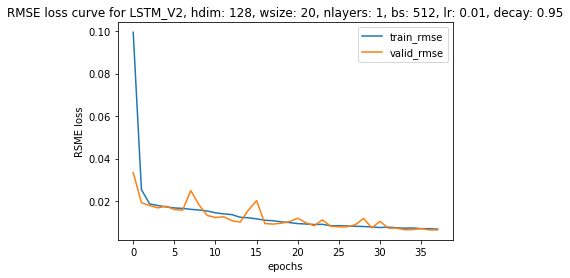

 88%|████████▊ | 308/352 [03:27<01:15,  1.71s/it]


100%|██████████| 352/352 [03:47<00:00,  1.55it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069]
0.00618
Epoch 39 | T: 4.54 | Train RMSE: 0.00690 | Valid RMSE: 0.00618


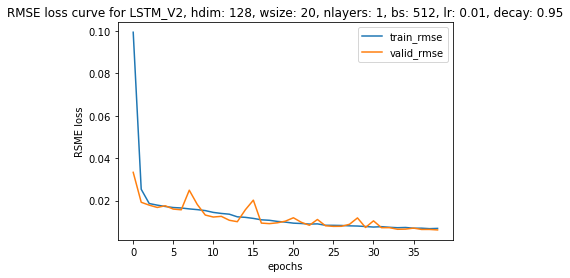

 88%|████████▊ | 308/352 [03:06<00:22,  1.98it/s]


100%|██████████| 352/352 [03:25<00:00,  1.71it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659]
0.00599
Epoch 40 | T: 4.28 | Train RMSE: 0.00659 | Valid RMSE: 0.00599


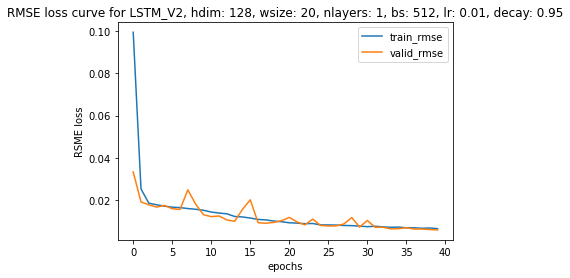

 88%|████████▊ | 308/352 [02:58<00:18,  2.34it/s]


100%|██████████| 352/352 [03:17<00:00,  1.78it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655]
0.00617
Epoch 41 | T: 4.18 | Train RMSE: 0.00655 | Valid RMSE: 0.00617


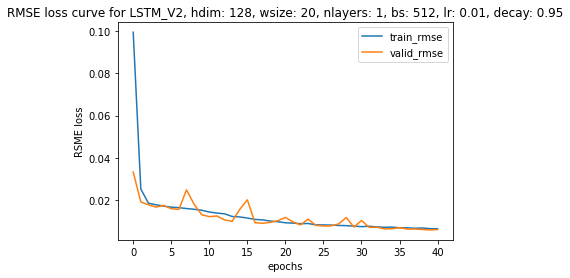

 88%|████████▊ | 308/352 [02:58<00:20,  2.18it/s]


100%|██████████| 352/352 [03:50<00:00,  1.53it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641]
0.00624
Epoch 42 | T: 4.39 | Train RMSE: 0.00641 | Valid RMSE: 0.00624


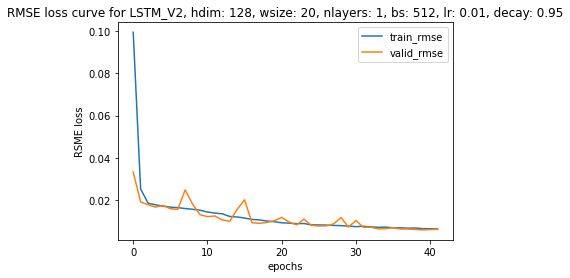

 88%|████████▊ | 308/352 [03:20<02:45,  3.76s/it]


100%|██████████| 352/352 [03:41<00:00,  1.59it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641]
0.00696
Epoch 43 | T: 4.19 | Train RMSE: 0.00641 | Valid RMSE: 0.00696


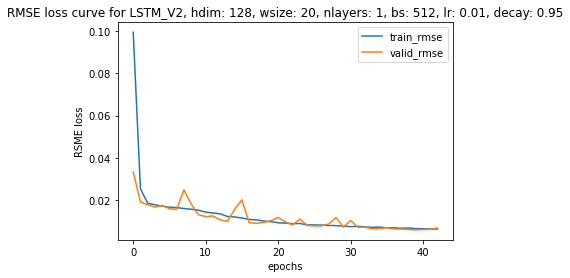

 88%|████████▊ | 308/352 [03:22<00:19,  2.30it/s]


100%|██████████| 352/352 [03:49<00:00,  1.54it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623]
0.006
Epoch 44 | T: 4.17 | Train RMSE: 0.00623 | Valid RMSE: 0.00600


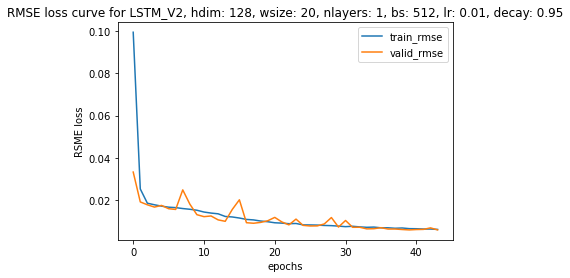

 88%|████████▊ | 308/352 [03:20<00:22,  1.91it/s]


100%|██████████| 352/352 [03:47<00:00,  1.55it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606]
0.00653
Epoch 45 | T: 4.16 | Train RMSE: 0.00606 | Valid RMSE: 0.00653


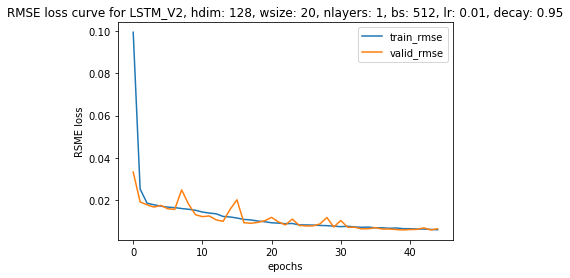

 88%|████████▊ | 308/352 [03:11<00:21,  2.06it/s]


100%|██████████| 352/352 [03:39<00:00,  1.60it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605]
0.00559
Epoch 46 | T: 4.01 | Train RMSE: 0.00605 | Valid RMSE: 0.00559


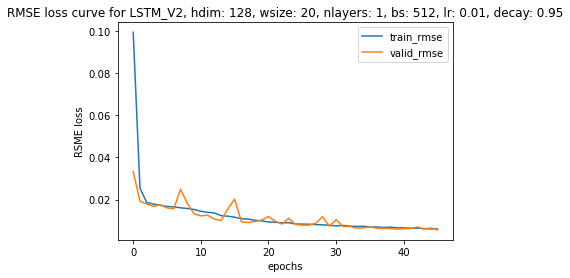

 88%|████████▊ | 308/352 [03:13<00:26,  1.69it/s]


100%|██████████| 352/352 [03:45<00:00,  1.56it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586]
0.00582
Epoch 47 | T: 4.13 | Train RMSE: 0.00586 | Valid RMSE: 0.00582


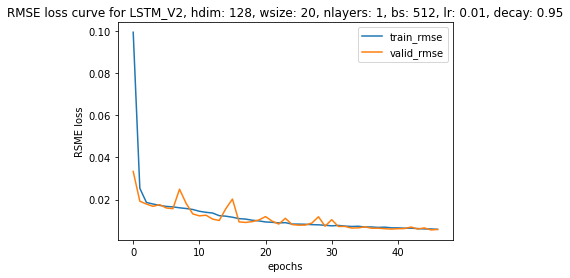

 88%|████████▊ | 308/352 [03:28<02:22,  3.23s/it]


100%|██████████| 352/352 [03:48<00:00,  1.54it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579]
0.00542
Epoch 48 | T: 4.14 | Train RMSE: 0.00579 | Valid RMSE: 0.00542


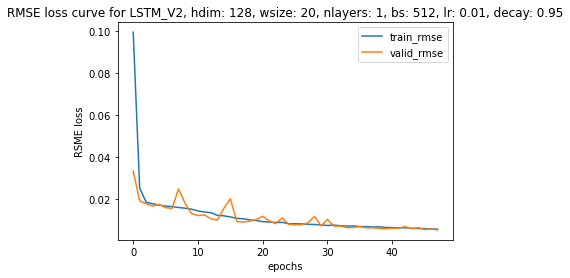

 88%|████████▊ | 308/352 [03:30<00:19,  2.28it/s]


100%|██████████| 352/352 [03:51<00:00,  1.52it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569]
0.00557
Epoch 49 | T: 4.61 | Train RMSE: 0.00569 | Valid RMSE: 0.00557


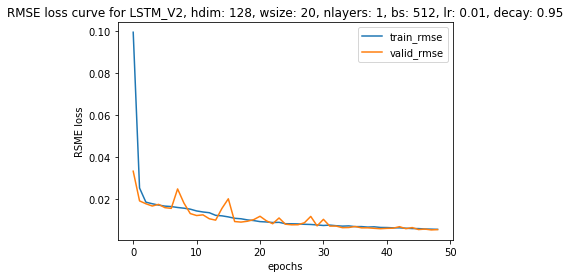

 88%|████████▊ | 308/352 [03:06<00:23,  1.90it/s]


100%|██████████| 352/352 [03:51<00:00,  1.52it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559]
0.00522
Epoch 50 | T: 4.22 | Train RMSE: 0.00559 | Valid RMSE: 0.00522


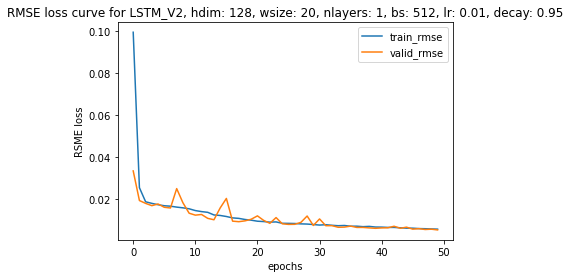

 88%|████████▊ | 308/352 [03:04<00:21,  2.03it/s]


100%|██████████| 352/352 [03:49<00:00,  1.53it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557]
0.00514
Epoch 51 | T: 4.19 | Train RMSE: 0.00557 | Valid RMSE: 0.00514


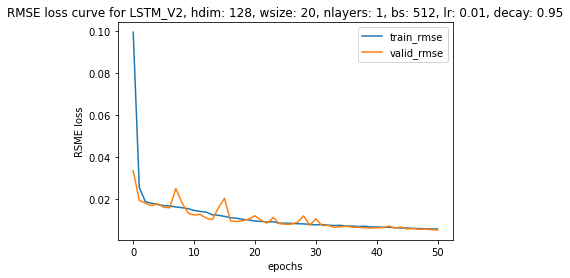

 88%|████████▊ | 308/352 [03:30<00:30,  1.45it/s]


100%|██████████| 352/352 [03:50<00:00,  1.53it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538]
0.00515
Epoch 52 | T: 4.45 | Train RMSE: 0.00538 | Valid RMSE: 0.00515


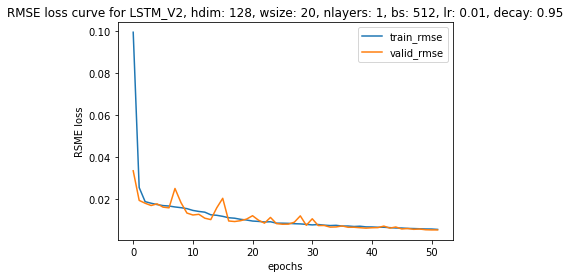

 88%|████████▊ | 308/352 [03:13<00:22,  1.94it/s]


100%|██████████| 352/352 [03:50<00:00,  1.53it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538]
0.00531
Epoch 53 | T: 4.30 | Train RMSE: 0.00538 | Valid RMSE: 0.00531


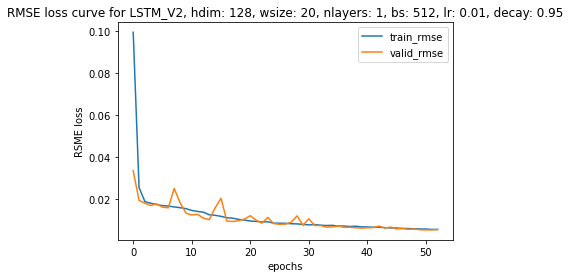

 88%|████████▊ | 308/352 [03:08<00:21,  2.09it/s]


100%|██████████| 352/352 [03:50<00:00,  1.52it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524]
0.00533
Epoch 54 | T: 4.23 | Train RMSE: 0.00524 | Valid RMSE: 0.00533


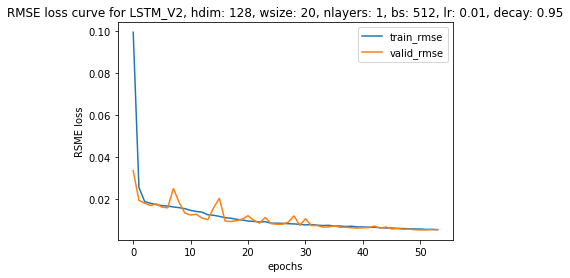

 88%|████████▊ | 308/352 [03:32<00:24,  1.82it/s]


100%|██████████| 352/352 [03:53<00:00,  1.51it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522]
0.005
Epoch 55 | T: 4.54 | Train RMSE: 0.00522 | Valid RMSE: 0.00500


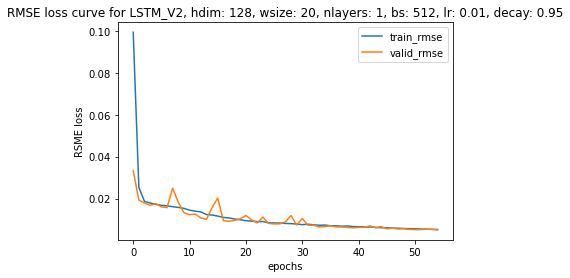

 88%|████████▊ | 308/352 [03:13<00:20,  2.18it/s]


100%|██████████| 352/352 [03:50<00:00,  1.53it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052]
0.00487
Epoch 56 | T: 4.22 | Train RMSE: 0.00520 | Valid RMSE: 0.00487


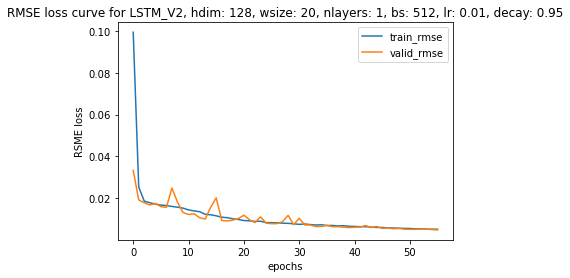

 88%|████████▊ | 308/352 [03:13<00:22,  1.99it/s]


100%|██████████| 352/352 [03:51<00:00,  1.52it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514]
0.0048
Epoch 57 | T: 4.25 | Train RMSE: 0.00514 | Valid RMSE: 0.00480


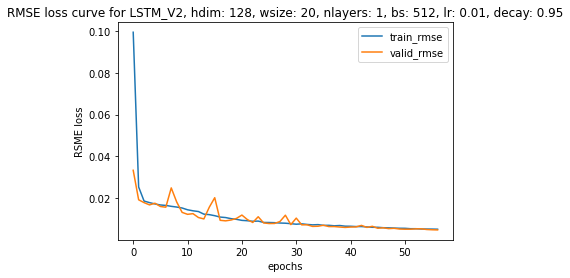

 88%|████████▊ | 308/352 [03:29<00:19,  2.23it/s]


100%|██████████| 352/352 [03:50<00:00,  1.53it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512]
0.00527
Epoch 58 | T: 4.56 | Train RMSE: 0.00512 | Valid RMSE: 0.00527


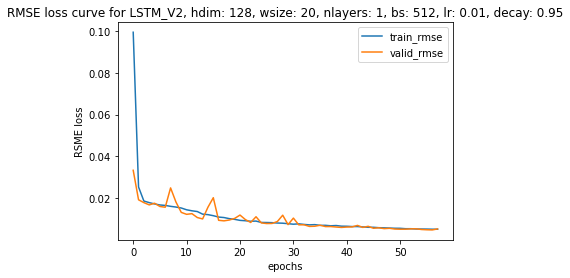

 88%|████████▊ | 308/352 [03:10<00:19,  2.32it/s]


100%|██████████| 352/352 [03:53<00:00,  1.50it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503]
0.00487
Epoch 59 | T: 4.26 | Train RMSE: 0.00503 | Valid RMSE: 0.00487


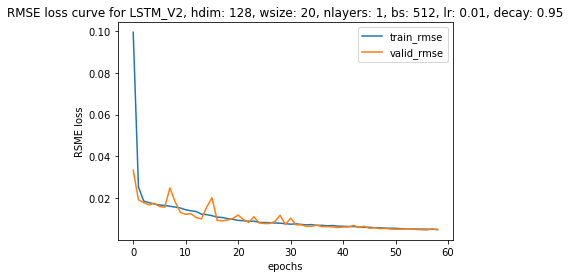

 88%|████████▊ | 308/352 [03:09<00:18,  2.40it/s]


100%|██████████| 352/352 [03:47<00:00,  1.55it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498]
0.00493
Epoch 60 | T: 4.15 | Train RMSE: 0.00498 | Valid RMSE: 0.00493


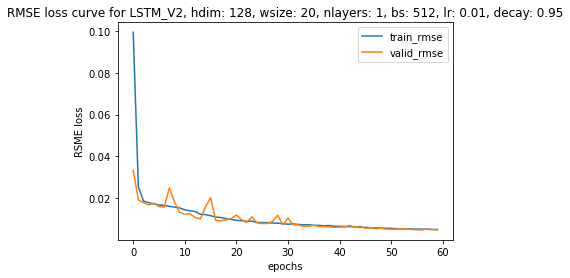

 88%|████████▊ | 308/352 [03:28<00:52,  1.19s/it]


100%|██████████| 352/352 [03:48<00:00,  1.54it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497]
0.00469
Epoch 61 | T: 4.52 | Train RMSE: 0.00497 | Valid RMSE: 0.00469


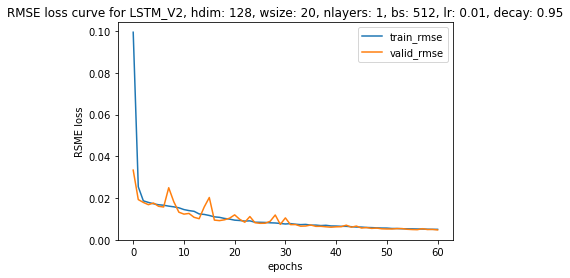

 88%|████████▊ | 308/352 [03:10<00:21,  2.06it/s]


100%|██████████| 352/352 [03:30<00:00,  1.67it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494]
0.00503
Epoch 62 | T: 4.28 | Train RMSE: 0.00494 | Valid RMSE: 0.00503


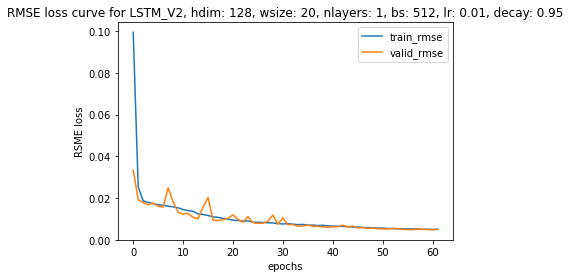

 88%|████████▊ | 308/352 [03:11<00:20,  2.10it/s]


100%|██████████| 352/352 [03:52<00:00,  1.51it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489]
0.00465
Epoch 63 | T: 4.23 | Train RMSE: 0.00489 | Valid RMSE: 0.00465


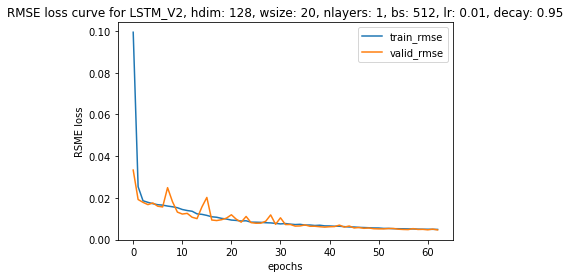

 88%|████████▊ | 308/352 [03:30<00:46,  1.06s/it]


100%|██████████| 352/352 [03:51<00:00,  1.52it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491]
0.00465
Epoch 64 | T: 4.47 | Train RMSE: 0.00491 | Valid RMSE: 0.00465


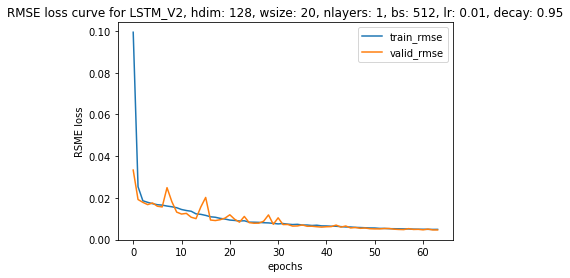

 88%|████████▊ | 308/352 [03:16<00:20,  2.13it/s]


100%|██████████| 352/352 [03:34<00:00,  1.64it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485]
0.00488
Epoch 65 | T: 4.24 | Train RMSE: 0.00485 | Valid RMSE: 0.00488


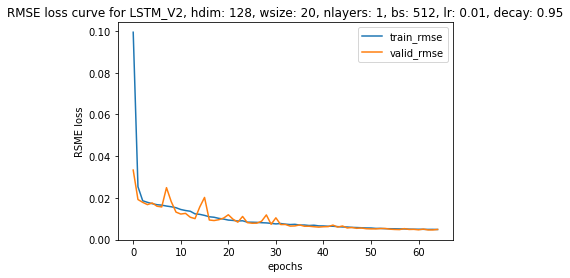

 88%|████████▊ | 308/352 [03:12<00:19,  2.21it/s]


100%|██████████| 352/352 [03:53<00:00,  1.51it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484]
0.0047
Epoch 66 | T: 4.28 | Train RMSE: 0.00484 | Valid RMSE: 0.00470


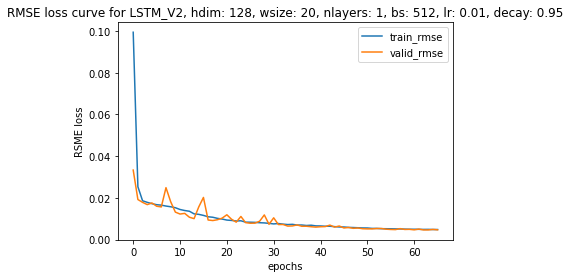

 88%|████████▊ | 308/352 [03:05<00:20,  2.15it/s]


100%|██████████| 352/352 [03:49<00:00,  1.53it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482]
0.00477
Epoch 67 | T: 4.44 | Train RMSE: 0.00482 | Valid RMSE: 0.00477


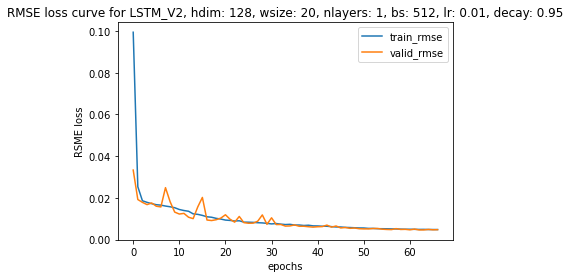

 88%|████████▊ | 308/352 [03:16<00:21,  2.05it/s]


100%|██████████| 352/352 [03:35<00:00,  1.63it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483]
0.00456
Epoch 68 | T: 4.22 | Train RMSE: 0.00483 | Valid RMSE: 0.00456


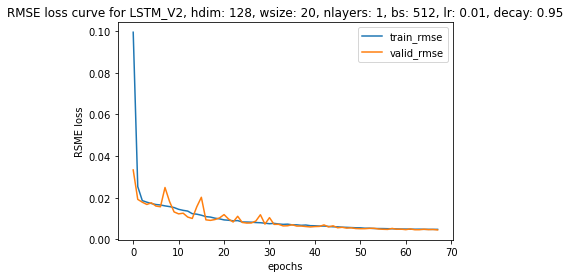

 88%|████████▊ | 308/352 [03:13<00:20,  2.15it/s]


100%|██████████| 352/352 [03:49<00:00,  1.54it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479]
0.0048
Epoch 69 | T: 4.20 | Train RMSE: 0.00479 | Valid RMSE: 0.00480


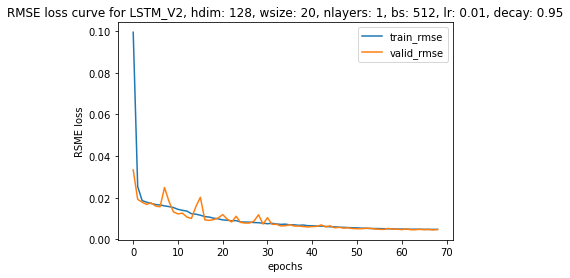

 88%|████████▊ | 308/352 [03:10<00:16,  2.65it/s]


100%|██████████| 352/352 [03:51<00:00,  1.52it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478]
0.00456
Epoch 70 | T: 4.22 | Train RMSE: 0.00478 | Valid RMSE: 0.00456


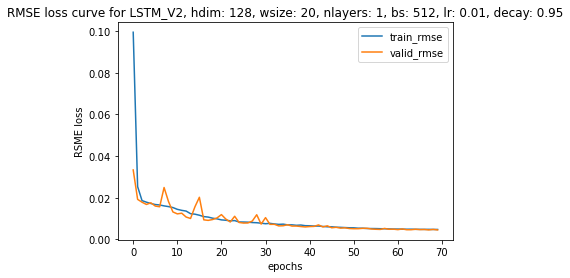

 88%|████████▊ | 308/352 [03:30<00:24,  1.83it/s]


100%|██████████| 352/352 [03:50<00:00,  1.52it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475]
0.00508
Epoch 71 | T: 4.48 | Train RMSE: 0.00475 | Valid RMSE: 0.00508


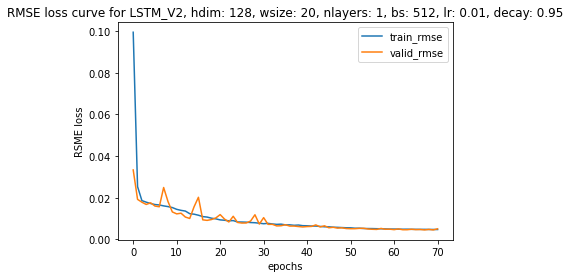

 88%|████████▊ | 308/352 [03:11<00:18,  2.35it/s]


100%|██████████| 352/352 [03:30<00:00,  1.67it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475]
0.00469
Epoch 72 | T: 4.15 | Train RMSE: 0.00475 | Valid RMSE: 0.00469


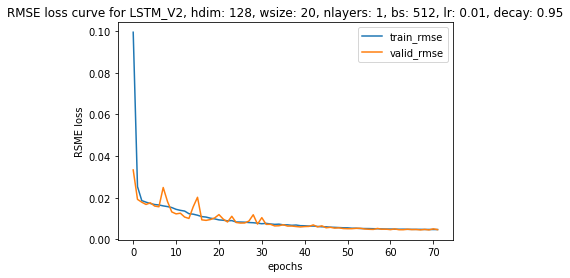

 88%|████████▊ | 308/352 [03:11<00:20,  2.20it/s]


100%|██████████| 352/352 [03:51<00:00,  1.52it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472]
0.00477
Epoch 73 | T: 4.23 | Train RMSE: 0.00472 | Valid RMSE: 0.00477


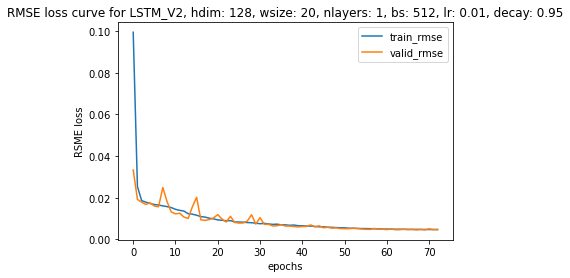

 88%|████████▊ | 308/352 [03:10<00:20,  2.19it/s]


100%|██████████| 352/352 [03:47<00:00,  1.54it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472]
0.00454
Epoch 74 | T: 4.16 | Train RMSE: 0.00472 | Valid RMSE: 0.00454


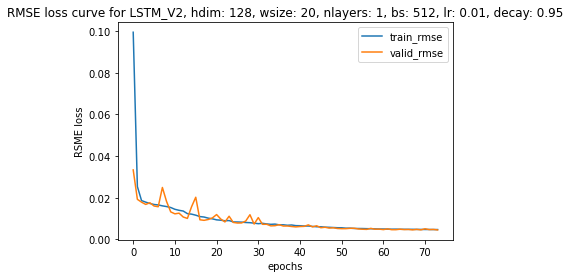

 88%|████████▊ | 308/352 [03:31<00:23,  1.85it/s]


100%|██████████| 352/352 [03:51<00:00,  1.52it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471]
0.00452
Epoch 75 | T: 4.54 | Train RMSE: 0.00471 | Valid RMSE: 0.00452


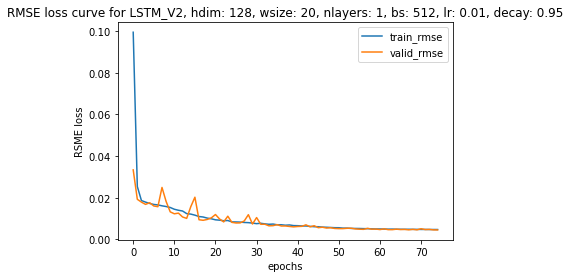

 88%|████████▊ | 308/352 [03:10<00:19,  2.29it/s]


100%|██████████| 352/352 [03:51<00:00,  1.52it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471]
0.00455
Epoch 76 | T: 4.22 | Train RMSE: 0.00471 | Valid RMSE: 0.00455


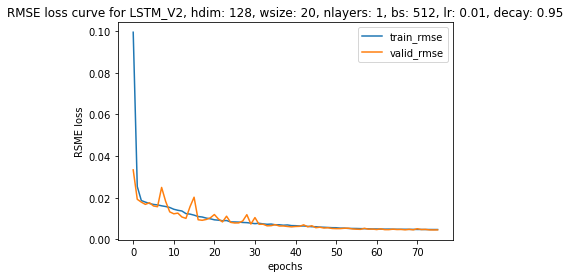

 88%|████████▊ | 308/352 [03:04<00:21,  2.05it/s]


100%|██████████| 352/352 [03:46<00:00,  1.56it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047]
0.00477
Epoch 77 | T: 4.14 | Train RMSE: 0.00470 | Valid RMSE: 0.00477


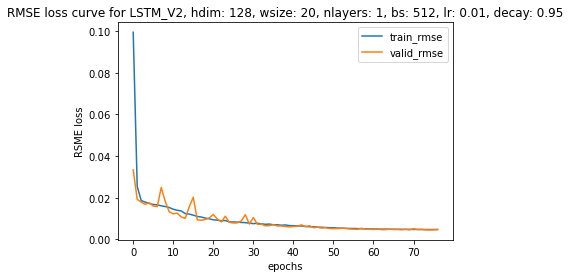

 88%|████████▊ | 308/352 [03:06<00:21,  2.07it/s]


100%|██████████| 352/352 [03:53<00:00,  1.51it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047, 0.00469]
0.0045
Epoch 78 | T: 4.52 | Train RMSE: 0.00469 | Valid RMSE: 0.00450


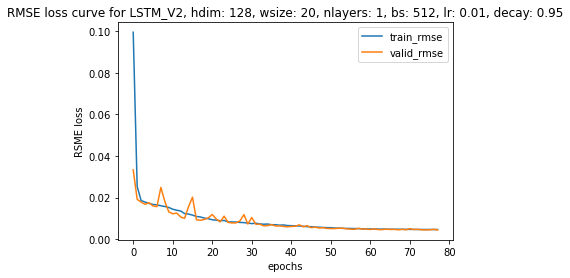

 88%|████████▊ | 308/352 [03:14<00:19,  2.26it/s]


100%|██████████| 352/352 [03:33<00:00,  1.65it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047, 0.00469, 0.00468]
0.0045
Epoch 79 | T: 4.20 | Train RMSE: 0.00468 | Valid RMSE: 0.00450


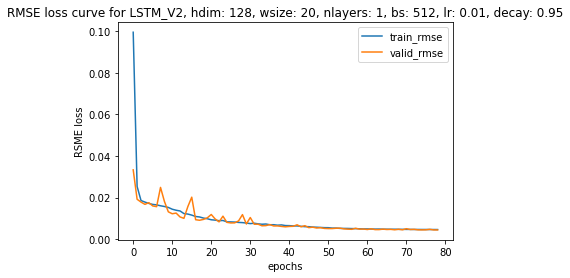

 88%|████████▊ | 308/352 [03:13<00:18,  2.37it/s]


100%|██████████| 352/352 [03:50<00:00,  1.53it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047, 0.00469, 0.00468, 0.00467]
0.00455
Epoch 80 | T: 4.24 | Train RMSE: 0.00467 | Valid RMSE: 0.00455


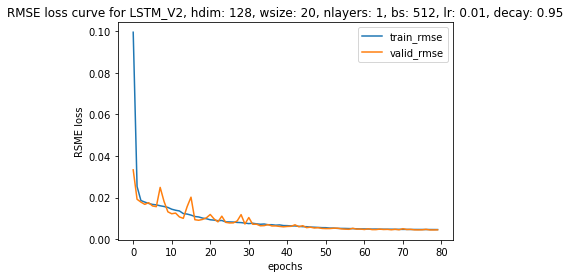

 88%|████████▊ | 308/352 [03:09<00:22,  1.99it/s]


100%|██████████| 352/352 [03:54<00:00,  1.50it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047, 0.00469, 0.00468, 0.00467, 0.00466]
0.00451
Epoch 81 | T: 4.51 | Train RMSE: 0.00466 | Valid RMSE: 0.00451


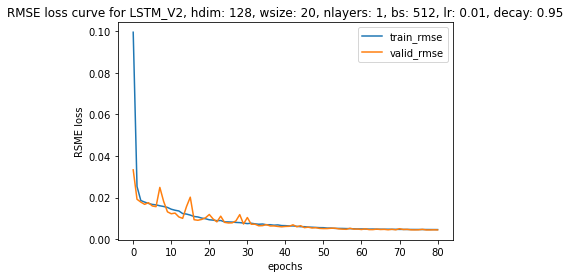

 88%|████████▊ | 308/352 [03:14<00:20,  2.11it/s]


100%|██████████| 352/352 [03:36<00:00,  1.63it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047, 0.00469, 0.00468, 0.00467, 0.00466, 0.00465]
0.00449
Epoch 82 | T: 4.28 | Train RMSE: 0.00465 | Valid RMSE: 0.00449


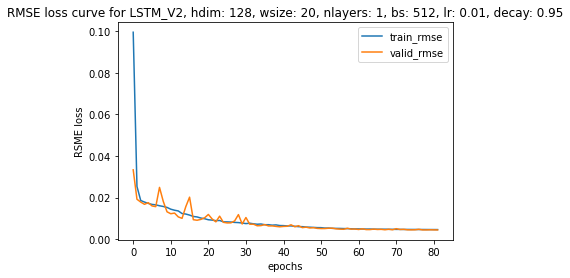

 88%|████████▊ | 308/352 [03:14<00:20,  2.11it/s]


100%|██████████| 352/352 [03:54<00:00,  1.50it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047, 0.00469, 0.00468, 0.00467, 0.00466, 0.00465, 0.00466]
0.00448
Epoch 83 | T: 4.32 | Train RMSE: 0.00466 | Valid RMSE: 0.00448


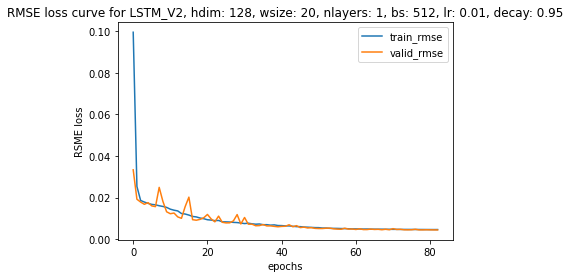

 88%|████████▊ | 308/352 [03:28<00:53,  1.22s/it]


100%|██████████| 352/352 [03:49<00:00,  1.54it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047, 0.00469, 0.00468, 0.00467, 0.00466, 0.00465, 0.00466, 0.00464]
0.00454
Epoch 84 | T: 4.43 | Train RMSE: 0.00464 | Valid RMSE: 0.00454


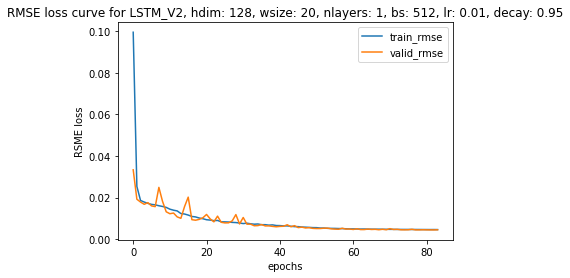

 88%|████████▊ | 308/352 [03:13<00:18,  2.38it/s]


100%|██████████| 352/352 [03:34<00:00,  1.64it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047, 0.00469, 0.00468, 0.00467, 0.00466, 0.00465, 0.00466, 0.00464, 0.00465]
0.00447
Epoch 85 | T: 4.29 | Train RMSE: 0.00465 | Valid RMSE: 0.00447


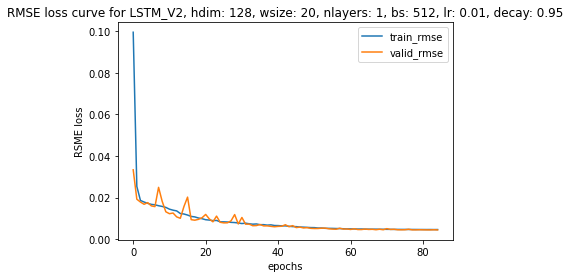

 88%|████████▊ | 308/352 [03:06<00:20,  2.16it/s]


100%|██████████| 352/352 [03:56<00:00,  1.49it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047, 0.00469, 0.00468, 0.00467, 0.00466, 0.00465, 0.00466, 0.00464, 0.00465, 0.00463]
0.00447
Epoch 86 | T: 4.33 | Train RMSE: 0.00463 | Valid RMSE: 0.00447


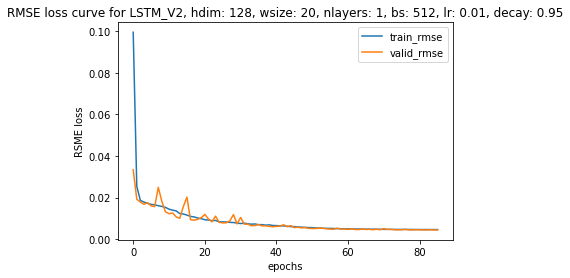

 88%|████████▊ | 308/352 [03:01<00:20,  2.16it/s]


100%|██████████| 352/352 [03:55<00:00,  1.49it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047, 0.00469, 0.00468, 0.00467, 0.00466, 0.00465, 0.00466, 0.00464, 0.00465, 0.00463, 0.00465]
0.00447
Epoch 87 | T: 4.59 | Train RMSE: 0.00465 | Valid RMSE: 0.00447


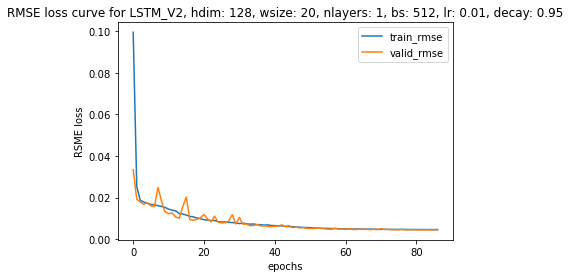

 88%|████████▊ | 308/352 [03:19<00:18,  2.32it/s]


100%|██████████| 352/352 [03:52<00:00,  1.52it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047, 0.00469, 0.00468, 0.00467, 0.00466, 0.00465, 0.00466, 0.00464, 0.00465, 0.00463, 0.00465, 0.00463]
0.00448
Epoch 88 | T: 4.28 | Train RMSE: 0.00463 | Valid RMSE: 0.00448


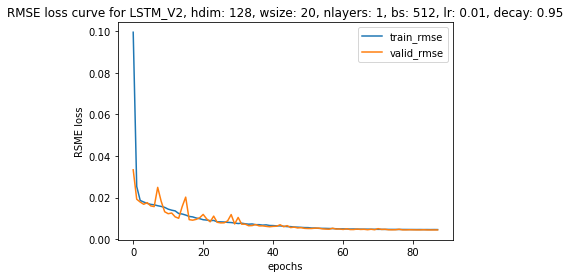

 88%|████████▊ | 308/352 [03:14<00:19,  2.25it/s]


100%|██████████| 352/352 [03:44<00:00,  1.57it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047, 0.00469, 0.00468, 0.00467, 0.00466, 0.00465, 0.00466, 0.00464, 0.00465, 0.00463, 0.00465, 0.00463, 0.00462]
0.00448
Epoch 89 | T: 4.12 | Train RMSE: 0.00462 | Valid RMSE: 0.00448


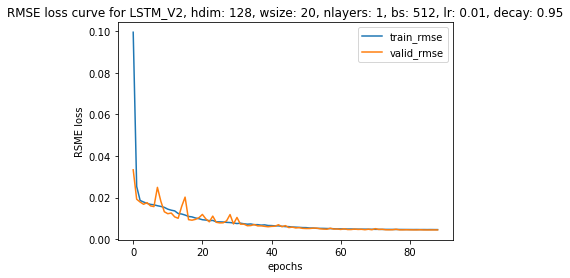

 88%|████████▊ | 308/352 [03:25<00:19,  2.23it/s]


100%|██████████| 352/352 [03:45<00:00,  1.56it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047, 0.00469, 0.00468, 0.00467, 0.00466, 0.00465, 0.00466, 0.00464, 0.00465, 0.00463, 0.00465, 0.00463, 0.00462, 0.00462]
0.00449
Epoch 90 | T: 4.10 | Train RMSE: 0.00462 | Valid RMSE: 0.00449


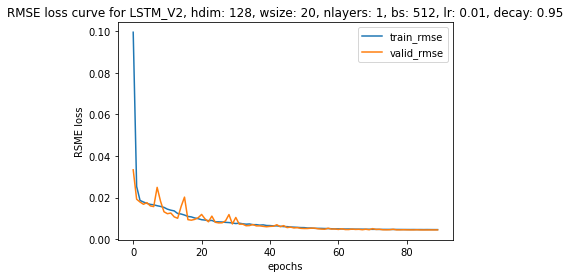

 88%|████████▊ | 308/352 [03:34<00:21,  2.04it/s]


100%|██████████| 352/352 [03:54<00:00,  1.50it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047, 0.00469, 0.00468, 0.00467, 0.00466, 0.00465, 0.00466, 0.00464, 0.00465, 0.00463, 0.00465, 0.00463, 0.00462, 0.00462, 0.00462]
0.00448
Epoch 91 | T: 4.68 | Train RMSE: 0.00462 | Valid RMSE: 0.00448


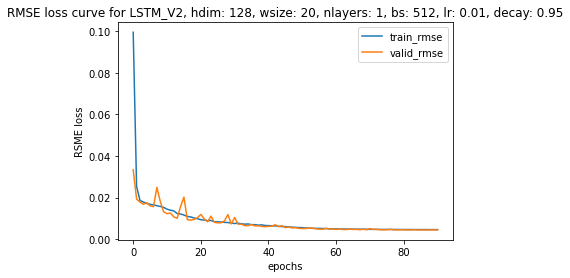

 88%|████████▊ | 308/352 [03:09<00:21,  2.09it/s]


100%|██████████| 352/352 [03:58<00:00,  1.48it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047, 0.00469, 0.00468, 0.00467, 0.00466, 0.00465, 0.00466, 0.00464, 0.00465, 0.00463, 0.00465, 0.00463, 0.00462, 0.00462, 0.00462, 0.00461]
0.00445
Epoch 92 | T: 4.34 | Train RMSE: 0.00461 | Valid RMSE: 0.00445


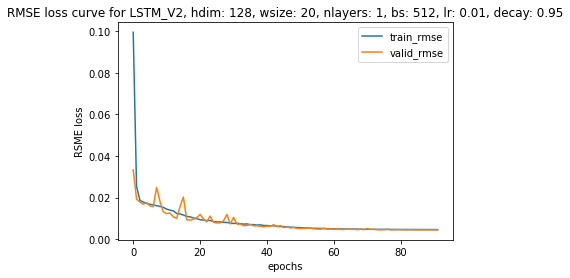

 88%|████████▊ | 308/352 [03:34<00:26,  1.63it/s]


100%|██████████| 352/352 [03:57<00:00,  1.48it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047, 0.00469, 0.00468, 0.00467, 0.00466, 0.00465, 0.00466, 0.00464, 0.00465, 0.00463, 0.00465, 0.00463, 0.00462, 0.00462, 0.00462, 0.00461, 0.00461]
0.00447
Epoch 93 | T: 4.57 | Train RMSE: 0.00461 | Valid RMSE: 0.00447


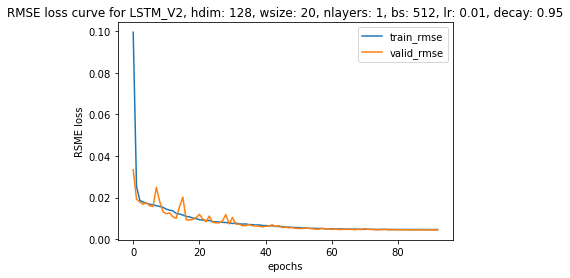

 88%|████████▊ | 308/352 [03:16<00:18,  2.41it/s]


100%|██████████| 352/352 [03:50<00:00,  1.53it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047, 0.00469, 0.00468, 0.00467, 0.00466, 0.00465, 0.00466, 0.00464, 0.00465, 0.00463, 0.00465, 0.00463, 0.00462, 0.00462, 0.00462, 0.00461, 0.00461, 0.00461]
0.00448
Epoch 94 | T: 4.24 | Train RMSE: 0.00461 | Valid RMSE: 0.00448


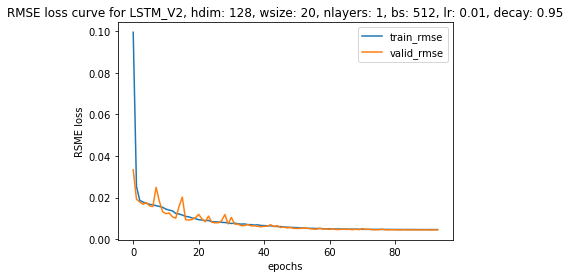

 88%|████████▊ | 308/352 [03:28<02:40,  3.65s/it]


100%|██████████| 352/352 [03:47<00:00,  1.55it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047, 0.00469, 0.00468, 0.00467, 0.00466, 0.00465, 0.00466, 0.00464, 0.00465, 0.00463, 0.00465, 0.00463, 0.00462, 0.00462, 0.00462, 0.00461, 0.00461, 0.00461, 0.0046]
0.00446
Epoch 95 | T: 4.16 | Train RMSE: 0.00460 | Valid RMSE: 0.00446


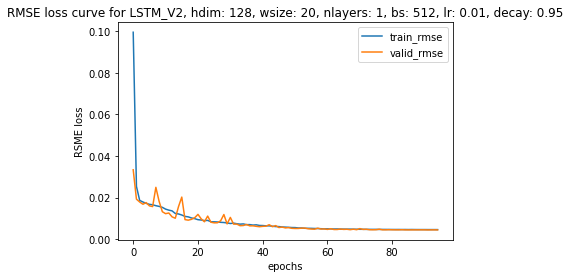

 88%|████████▊ | 308/352 [03:26<00:17,  2.55it/s]


100%|██████████| 352/352 [03:46<00:00,  1.55it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047, 0.00469, 0.00468, 0.00467, 0.00466, 0.00465, 0.00466, 0.00464, 0.00465, 0.00463, 0.00465, 0.00463, 0.00462, 0.00462, 0.00462, 0.00461, 0.00461, 0.00461, 0.0046, 0.0046]
0.00448
Epoch 96 | T: 4.49 | Train RMSE: 0.00460 | Valid RMSE: 0.00448


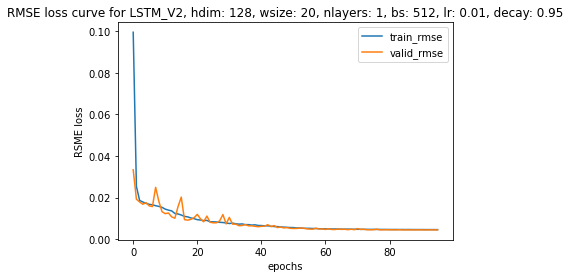

 88%|████████▊ | 308/352 [03:10<00:19,  2.25it/s]


100%|██████████| 352/352 [03:29<00:00,  1.68it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047, 0.00469, 0.00468, 0.00467, 0.00466, 0.00465, 0.00466, 0.00464, 0.00465, 0.00463, 0.00465, 0.00463, 0.00462, 0.00462, 0.00462, 0.00461, 0.00461, 0.00461, 0.0046, 0.0046, 0.0046]
0.00449
Epoch 97 | T: 4.25 | Train RMSE: 0.00460 | Valid RMSE: 0.00449


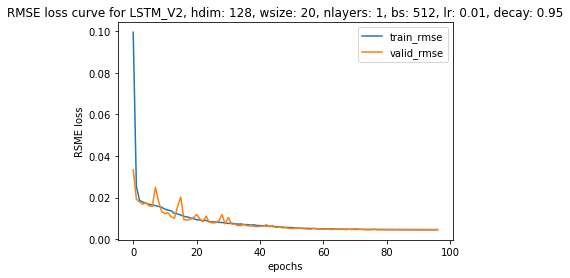

 88%|████████▊ | 308/352 [03:08<00:21,  2.02it/s]


100%|██████████| 352/352 [03:56<00:00,  1.49it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047, 0.00469, 0.00468, 0.00467, 0.00466, 0.00465, 0.00466, 0.00464, 0.00465, 0.00463, 0.00465, 0.00463, 0.00462, 0.00462, 0.00462, 0.00461, 0.00461, 0.00461, 0.0046, 0.0046, 0.0046, 0.00459]
0.00445
Epoch 98 | T: 4.29 | Train RMSE: 0.00459 | Valid RMSE: 0.00445


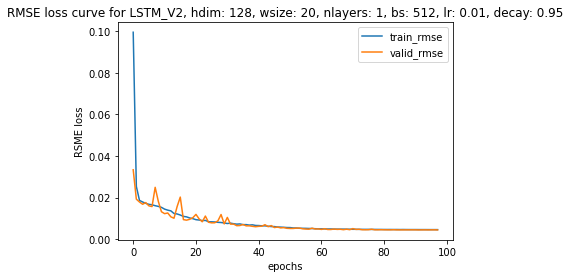

 88%|████████▊ | 308/352 [03:39<00:45,  1.02s/it]


100%|██████████| 352/352 [03:57<00:00,  1.48it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047, 0.00469, 0.00468, 0.00467, 0.00466, 0.00465, 0.00466, 0.00464, 0.00465, 0.00463, 0.00465, 0.00463, 0.00462, 0.00462, 0.00462, 0.00461, 0.00461, 0.00461, 0.0046, 0.0046, 0.0046, 0.00459, 0.00459]
0.00447
Epoch 99 | T: 4.59 | Train RMSE: 0.00459 | Valid RMSE: 0.00447


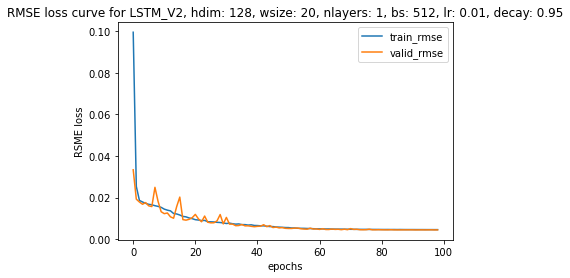

 88%|████████▊ | 308/352 [03:15<00:20,  2.16it/s]


100%|██████████| 352/352 [03:47<00:00,  1.55it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047, 0.00469, 0.00468, 0.00467, 0.00466, 0.00465, 0.00466, 0.00464, 0.00465, 0.00463, 0.00465, 0.00463, 0.00462, 0.00462, 0.00462, 0.00461, 0.00461, 0.00461, 0.0046, 0.0046, 0.0046, 0.00459, 0.00459, 0.0046]
0.00451
Epoch 100 | T: 4.15 | Train RMSE: 0.00460 | Valid RMSE: 0.00451


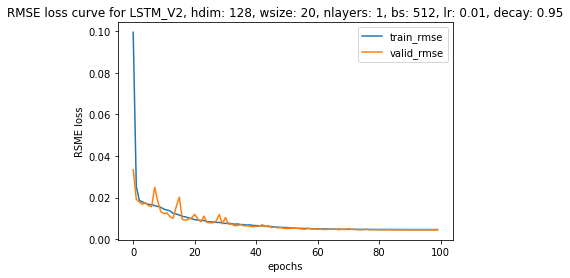

 88%|████████▊ | 308/352 [03:12<00:20,  2.16it/s]


100%|██████████| 352/352 [03:40<00:00,  1.60it/s]


[0.09942, 0.02535, 0.01862, 0.01787, 0.01723, 0.01674, 0.01653, 0.01609, 0.01575, 0.01529, 0.01444, 0.01395, 0.0136, 0.01235, 0.01211, 0.01161, 0.01095, 0.01072, 0.01019, 0.00986, 0.00937, 0.0092, 0.00893, 0.00903, 0.00837, 0.00834, 0.00827, 0.0081, 0.00801, 0.00779, 0.00753, 0.00771, 0.00742, 0.00722, 0.00733, 0.00698, 0.007, 0.00677, 0.0069, 0.00659, 0.00655, 0.00641, 0.00641, 0.00623, 0.00606, 0.00605, 0.00586, 0.00579, 0.00569, 0.00559, 0.00557, 0.00538, 0.00538, 0.00524, 0.00522, 0.0052, 0.00514, 0.00512, 0.00503, 0.00498, 0.00497, 0.00494, 0.00489, 0.00491, 0.00485, 0.00484, 0.00482, 0.00483, 0.00479, 0.00478, 0.00475, 0.00475, 0.00472, 0.00472, 0.00471, 0.00471, 0.0047, 0.00469, 0.00468, 0.00467, 0.00466, 0.00465, 0.00466, 0.00464, 0.00465, 0.00463, 0.00465, 0.00463, 0.00462, 0.00462, 0.00462, 0.00461, 0.00461, 0.00461, 0.0046, 0.0046, 0.0046, 0.00459, 0.00459, 0.0046, 0.00459]


 10%|█         | 100/1000 [7:11:12<64:40:54, 258.73s/it]

0.00449


In [42]:
train_rmse = []
valid_rmse = []
min_rmse = 10e8

for i in tqdm(range(num_epoch)):
    start = time.time()

    model.train() # if you use dropout or batchnorm. 
    train_rmse.append(train_epoch(train_loader, model, optimizer, loss_fun))
    print(train_rmse)
    
    model.eval()
    val_rmse = eval_epoch(valid_loader, model, loss_fun)
    valid_rmse.append(val_rmse)
    print(val_rmse)

    # save the best model
    if valid_rmse[-1] < min_rmse:
        min_rmse = valid_rmse[-1] 
        best_model = model
        
        # torch.save([best_model, i, get_lr(optimizer)], name + ".pth")

    end = time.time()
    
    # Early Stopping
    if (len(train_rmse) > 100 and np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
        torch.save(best_model.state_dict(), f'lstm_v2_hdim_{hidden_dim}_wsize_{window_size}_interval_{interval}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}_epoch_{i+1}.pt')    
        break       

    # Learning Rate Decay        
    scheduler.step()
    
    print("Epoch {} | T: {:0.2f} | Train RMSE: {:0.5f} | Valid RMSE: {:0.5f}".format(i + 1, (end-start) / 60, train_rmse[-1], valid_rmse[-1]))

    plt.figure()
    plt.plot(train_rmse, label="train_rmse")
    plt.plot(valid_rmse, label="valid_rmse")
    plt.xlabel('epochs')
    plt.ylabel('RSME loss')
    plt.title(f'RMSE loss curve for LSTM_V2, hdim: {hidden_dim}, wsize: {window_size}, nlayers: {num_layers}, bs: {batch_size}, lr: {learning_rate}, decay: {decay_rate}')
    plt.legend()
    plt.savefig(f'lstm_v2_loss_curve_v1_hdim_{hidden_dim}_wsize_{window_size}_interval_{interval}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}.png')
    plt.show()
    

# Evaluation and Submission

In [43]:
torch.save(best_model.state_dict(), f'Finished_lstm_v2_hdim_{hidden_dim}_wsize_{window_size}_interval_{interval}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}_epoch_{i+1}.pt')

In [60]:
model.load_state_dict(torch.load(f'Finished_lstm_v2_hdim_{hidden_dim}_wsize_{window_size}_interval_{interval}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}.pt'))
best_model = model

In [61]:
best_model

MyLSTM(
  (lstm): LSTM(76, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=60, bias=True)
)

In [90]:
test_path = "./val_in/"
test_pkl_list = glob(os.path.join(test_path, '*'))
test_pkl_list.sort()

test_preds = []
for idx in range(len(test_pkl_list)):
    with open(test_pkl_list[idx], 'rb') as f:
        test_sample = pickle.load(f)
        pred_id = np.where(test_sample["track_id"] == test_sample['agent_id'])[0][0]
        inp_scene = np.dstack([test_sample['p_in'], test_sample['v_in']])

        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        
        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
        inp = inp.reshape(1, -1)
        
        inp_data = torch.from_numpy(inp).float().unsqueeze(0).to(device)

        # post-processing for LSTM
        
        
        output, hidden = best_model(inp_data)
        predictions = output.cpu().data.numpy().reshape(30, 2)

        # De-Normalization ! 
        predictions = predictions * (max_vecs[:2] - min_vecs[:2]) +  min_vecs[:2]
        test_preds.append(predictions)

In [91]:
print(test_preds[0].shape)
print(test_preds[0])

(30, 2)
[[1712.91508926  337.16684041]
 [1713.56413242  337.88882003]
 [1715.95262787  338.75241647]
 [1716.0828943   339.53909657]
 [1717.74628848  340.62739954]
 [1719.91909518  341.20339954]
 [1720.09118837  342.05984097]
 [1721.83709157  342.83602851]
 [1722.05746242  343.71188444]
 [1722.31945195  344.61605501]
 [1725.25606528  345.3854802 ]
 [1726.31005809  346.0998249 ]
 [1725.33534884  346.94374507]
 [1726.72364362  347.9142958 ]
 [1729.12920272  348.50593647]
 [1729.94648935  349.4827042 ]
 [1730.5970932   349.83986565]
 [1731.99870595  351.02203448]
 [1731.73578     351.841981  ]
 [1733.4719028   352.41462164]
 [1732.42925108  353.16567939]
 [1734.75979254  354.02002668]
 [1737.46188466  354.66155608]
 [1736.83999769  355.44476775]
 [1735.04155093  355.98686871]
 [1739.75871499  356.75031684]
 [1739.71387088  357.58769279]
 [1742.36414776  358.51568431]
 [1742.41565086  358.77461709]
 [1742.78605702  359.51849802]]


# Generate Submission File

### Steps to create submission file 
Run the below cells. The last cell will generate a submission file "test_submission.csv" that you can submit to Kaggle.

In [92]:
# Submission Files
sample_sub = pd.read_csv('sample_submission.csv')

In [71]:
# # Save for later use
# predictions = np.concatenate(test_preds).reshape(len(test_preds), -1)#.astype(int)
# sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
# sub_df["ID"] = sub_df["ID"].astype(int)
# sub_df.to_csv(f'test_submission_lstm_hdim_{hidden_dim}_wsize_{window_size}_interval_{interval}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}.csv', index=None)

In [93]:
# Convert to float
predictions = np.concatenate(test_preds).reshape(len(test_preds), -1)
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
sub_df["ID"] = sub_df["ID"].astype(int)
sub_df.to_csv(f'test_submission_lstm_v2_hdim_{hidden_dim}_wsize_{window_size}_interval_{interval}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}.csv', index=None)

In [94]:
sub_df

ID           v1           v2           v3           v4           v5  \
0     10002  1712.915089   337.166840  1713.564132   337.888820  1715.952628   
1     10015   725.637744  1229.916045   725.118499  1229.375010   725.569028   
2     10019   575.056796  1246.230534   575.245906  1246.348015   575.440082   
3     10028  1693.182260   315.884922  1693.402558   316.327516  1694.314588   
4      1003  2122.854413   676.766950  2122.183228   676.046629  2119.473021   
...     ...          ...          ...          ...          ...          ...   
3195   9897   256.570298   806.186044   256.821007   806.016394   257.042154   
3196     99   588.583745  1154.753672   588.641812  1154.233164   588.773708   
3197   9905  1756.418138   444.872979  1756.182682   445.247059  1755.607499   
3198   9910   575.413382  1290.401503   575.420485  1289.876143   575.489130   
3199   9918   584.953050  1165.742457   584.940350  1165.176725   585.337043   

               v6           v7           v8           v9  ...          v51  \
0      338.752416  1716.082894   339.539097  1717.746288  ...  1739.758715   
1     1228.560473   725.134480  1229.103736   725.561552  ...   723.269511   
2     1246.401137   575.808956  1246.130498   575.782521  ...   581.207036   
3      316.887266  1694.158182   317.433155  1695.567041  ...  1709.046135   
4      674.809107  2119.598813   673.907915  2117.384221  ...  2093.397508   
...           ...          ...          ...          ...  ...          ...   
3195   805.782501   257.220769   805.694590   257.524715  ...   261.765275   
3196  1153.696326   588.839765  1153.019659   588.891768  ...   590.300972   
3197   445.768526  1756.244174   445.934641  1755.249796  ...  1752.783402   
3198  1289.412576   575.217879  1289.382663   575.516872  ...   574.293457   
3199  1163.146428   585.488091  1162.419936   585.624801  ...   587.714126   

              v52          v53          v54          v55          v56  \
0      356.750317  1739.713871   357.587693  1742.364148   358.515684   
1     1225.223067   723.423060  1224.764791   723.209927  1225.445481   
2     1244.791370   581.527107  1244.628704   581.414198  1244.561044   
3      328.549122  1709.242448   329.086221  1710.647276   329.525848   
4      652.493907  2092.542306   651.479219  2090.630484   650.275301   
...           ...          ...          ...          ...          ...   
3195   801.534853   262.016792   801.140543   262.068671   801.220047   
3196  1140.331439   590.438496  1139.733170   590.366847  1139.388545   
3197   453.060167  1752.040036   453.515457  1753.138057   453.778067   
3198  1283.219876   574.320226  1282.426719   573.740785  1282.840930   
3199  1141.777804   587.987955  1140.155587   587.344554  1140.117179   

              v57          v58          v59          v60  
0     1742.415651   358.774617  1742.786057   359.518498  
1      723.241980  1224.816197   723.085118  1224.977656  
2      581.814216  1244.749879   581.984989  1244.679390  
3     1710.544081   330.010737  1710.939731   330.363369  
4     2089.920141   649.735517  2089.389463   648.826132  
...           ...          ...          ...          ...  
3195   262.343006   800.924922   262.554709   800.675818  
3196   590.461193  1138.772814   590.665066  1138.307870  
3197  1751.579742   454.099267  1751.390012   454.434716  
3198   573.938232  1282.284949   573.852014  1282.056354  
3199   587.626454  1138.746163   588.092505  1138.090978  

[3200 rows x 61 columns]

In [ ]:
# Ensemble Method 